In [1]:
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plot
from datetime import datetime
from fbprophet import Prophet
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
df = fdr.DataReader('KS11','2000')
df.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-10-05,2962.17,2998.17,2998.17,2940.59,840560000.0,-0.0189
2021-10-06,2908.31,2986.06,2993.47,2908.30,901720000.0,-0.0182
2021-10-07,2959.46,2936.87,2961.53,2927.60,595380000.0,0.0176
2021-10-08,2956.30,2977.82,2978.08,2949.01,668950000.0,-0.0011
2021-10-12,2916.38,2950.22,2950.94,2901.51,647700.0,-0.0135


In [3]:
data = df.reset_index()
data.head()

,Date,Close,Open,High,Low,Volume,Change
0,2000-01-04,1059.04,1028.33,1066.18,1016.59,195900000.0,0.0301
1,2000-01-05,986.31,1006.87,1026.52,984.05,257700000.0,-0.0687
2,2000-01-06,960.79,1013.95,1014.90,953.50,203520000.0,-0.0259
3,2000-01-07,948.65,949.17,970.16,930.84,215660000.0,-0.0126
4,2000-01-10,987.24,979.67,994.94,965.02,240180000.0,0.0407


In [4]:
prcp_data = data.rename(columns={'Date': 'ds', 'Close': 'y'})[['ds', 'y']]
prcp_data.head()

,ds,y
0,2000-01-04,1059.04
1,2000-01-05,986.31
2,2000-01-06,960.79
3,2000-01-07,948.65
4,2000-01-10,987.24


In [5]:
prcp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5376 entries, 0 to 5375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      5376 non-null   datetime64[ns]
 1   y       5376 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 84.1 KB


In [6]:
prcp_data.isnull().sum()

ds    0
y     0
dtype: int64

In [30]:
m = NeuralProphet(
    n_lags=12,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
    batch_size=32,
    epochs=14,
    learning_rate=0.1,
)
metrics = m.fit(prcp_data, freq='5d')

INFO: nprophet - _handle_missing_data: 515 NaN values in column y were auto-imputed.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[14/14]: 100%|█| 14/14 [00:01<00:00,  8.27it/s, SmoothL1Loss=0.000191, MAE


INFO: nprophet - _handle_missing_data: 515 NaN values in column y were auto-imputed.


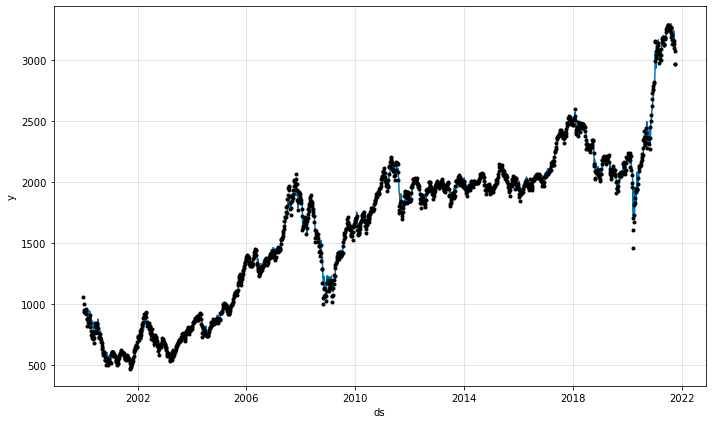

In [31]:
future = m.make_future_dataframe(prcp_data, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

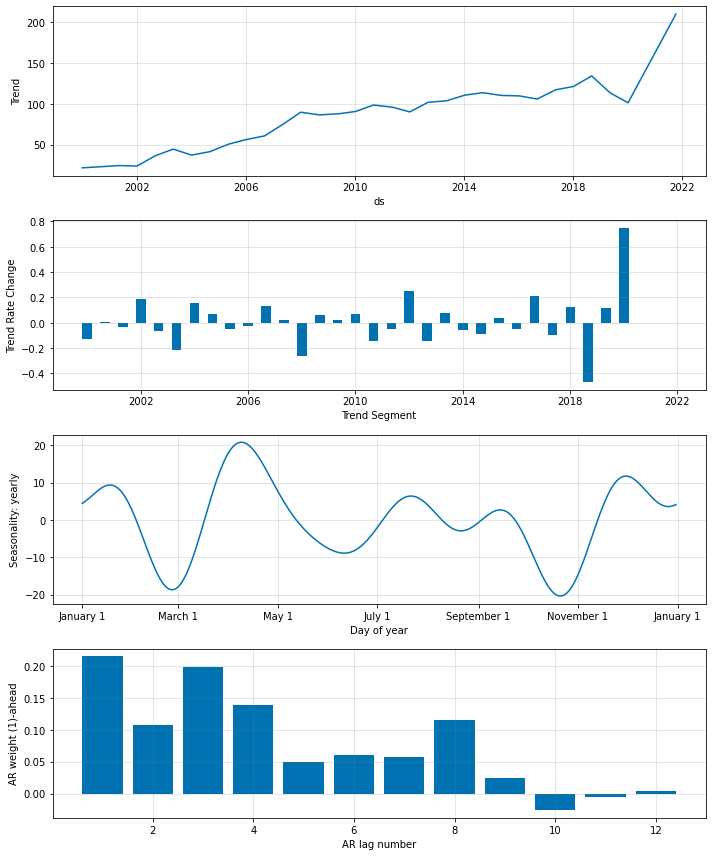

In [9]:
m = m.highlight_nth_step_ahead_of_each_forecast(1) # temporary workaround to plot actual AR weights
fig_param = m.plot_parameters()

INFO: nprophet - _handle_missing_data: 2577 missing dates were added.
INFO: nprophet - _handle_missing_data: 2577 NaN values in column y were auto-imputed.
Epoch[300/300]: 100%|█| 300/300 [07:12<00:00,  1.44s/it, SmoothL1Loss=0.000672,
INFO: nprophet - _handle_missing_data: 515 NaN values in column y were auto-imputed.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[10/10]: 100%|█| 10/10 [00:01<00:00,  8.66it/s, SmoothL1Loss=0.00606, MAE=
INFO: nprophet - _handle_missing_data: 515 NaN values in column y were auto-imputed.


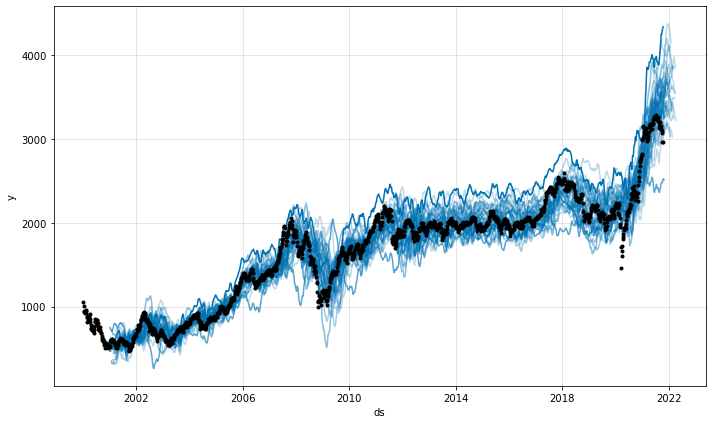

In [33]:
m = NeuralProphet(
    n_lags=6*12,
    n_forecasts=3*12,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
    batch_size=64,
    epochs=10,    
    learning_rate=1.0,
)
metrics = m.fit(prcp_data, freq='5d')
future = m.make_future_dataframe(prcp_data, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

In [34]:
model = NeuralProphet(
    n_lags=6*12,
    n_forecasts=3*12,
    changepoints_range=0.95,
    n_changepoints=30,
    weekly_seasonality=False,
    batch_size=64,
    epochs=10,    
    learning_rate=1.0,
)
model.fit(prcp_data, 
          freq='D',
          valid_p=0.2,
          epochs=300)

INFO: nprophet - _handle_missing_data: 2577 missing dates were added.
INFO: nprophet - _handle_missing_data: 2577 NaN values in column y were auto-imputed.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
Epoch[300/300]: 100%|█| 300/300 [03:07<00:00,  1.60it/s, SmoothL1Loss=0.000406,


,SmoothL1Loss,MAE,RegLoss
0,0.138848,810.409893,0.0
1,0.001559,97.661948,0.0
2,0.000864,73.008676,0.0
3,0.000811,70.238674,0.0
4,0.000780,68.542655,0.0
...,...,...,...
295,0.000419,47.910298,0.0
296,0.000415,47.451034,0.0
297,0.000411,47.303067,0.0
298,0.000407,46.904514,0.0


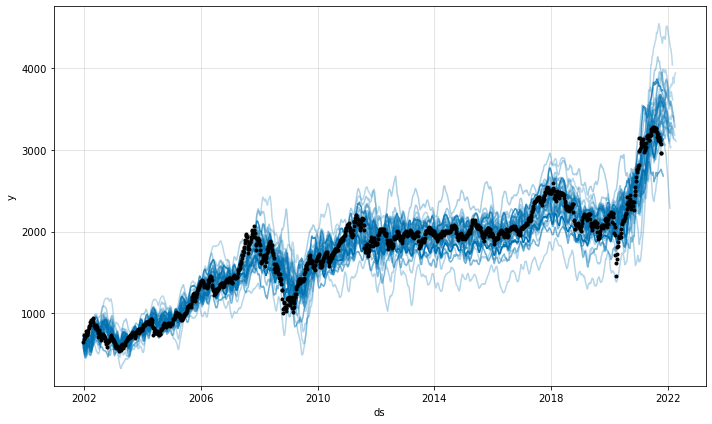

In [11]:
fig = m.plot(forecast[144:6*288])

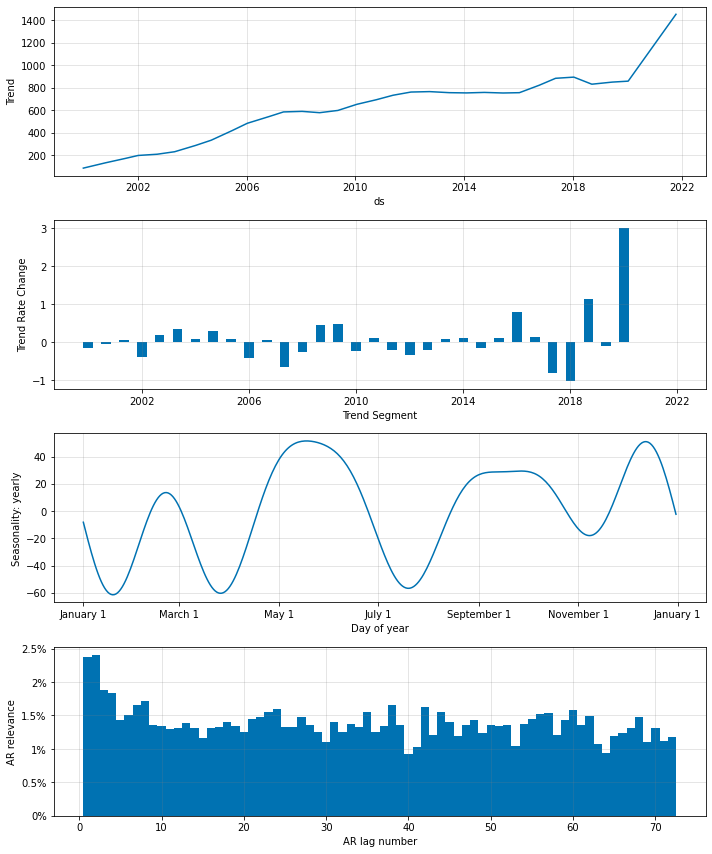

In [12]:
fig_param = m.plot_parameters()

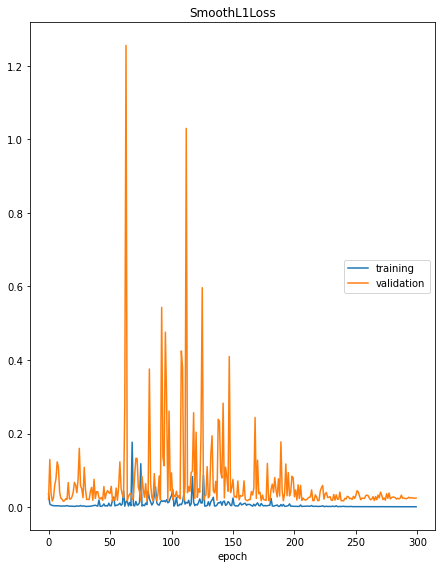

Epoch[300/300]: 100%|█| 300/300 [01:16<00:00,  3.93it/s, SmoothL1Loss=0.00122, 


In [15]:
model = NeuralProphet(n_changepoints=100,
                      trend_reg=0.05,
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False)
metrics = model.fit(prcp_data, validate_each_epoch=True, 
                    valid_p=0.2, freq='D', 
                    plot_live_loss=True, 
                    epochs=300)
future = model.make_future_dataframe(prcp_data, periods=365, n_historic_predictions=len(df)) 
forecast = model.predict(future)

In [16]:
def plot_forecast(model, data, periods, historic_pred=True, highlight_steps_ahead=None):    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        mbodel.plot_last_forecast(forecast)
    else:    
        model.plot(forecast)

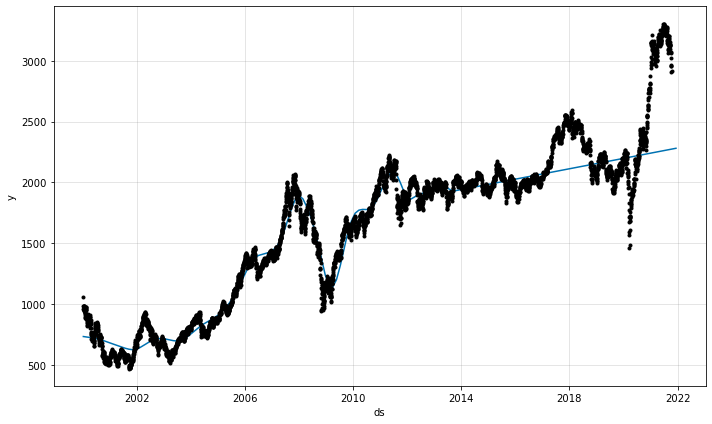

In [17]:
plot_forecast(model, prcp_data, periods=60)

Text(0.5, 1.0, 'KOSPI INDEX')

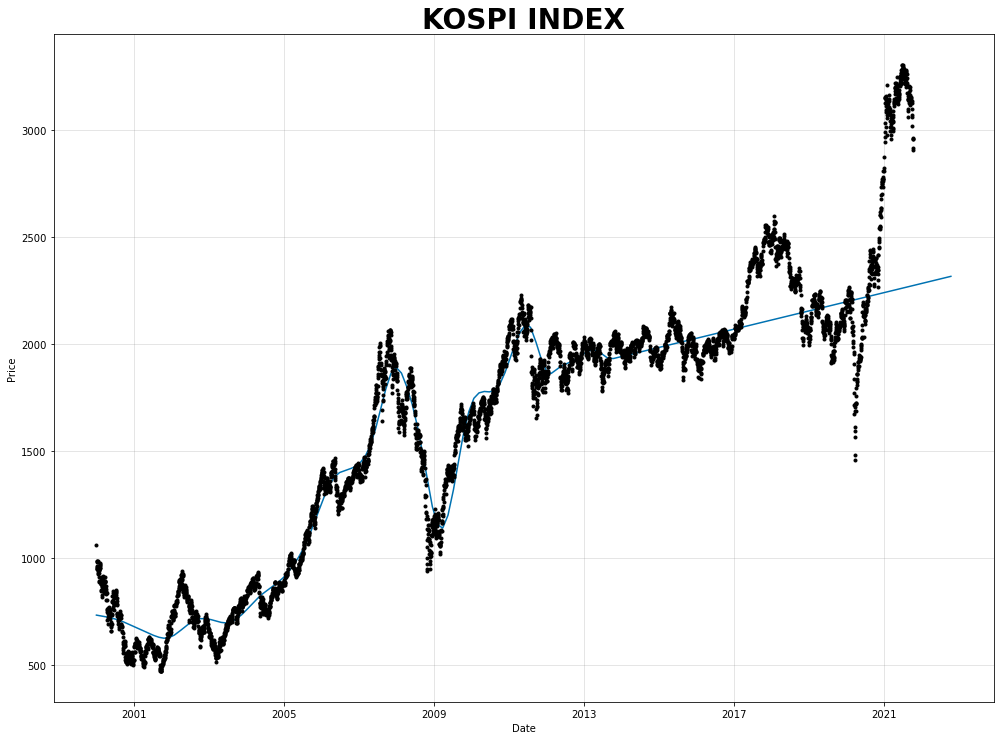

In [18]:
fig, ax = plot.subplots(figsize=(14, 10)) 
model.plot(forecast, xlabel="Date", ylabel="Price", ax=ax)
ax.set_title("KOSPI INDEX", fontsize=28, fontweight="bold")

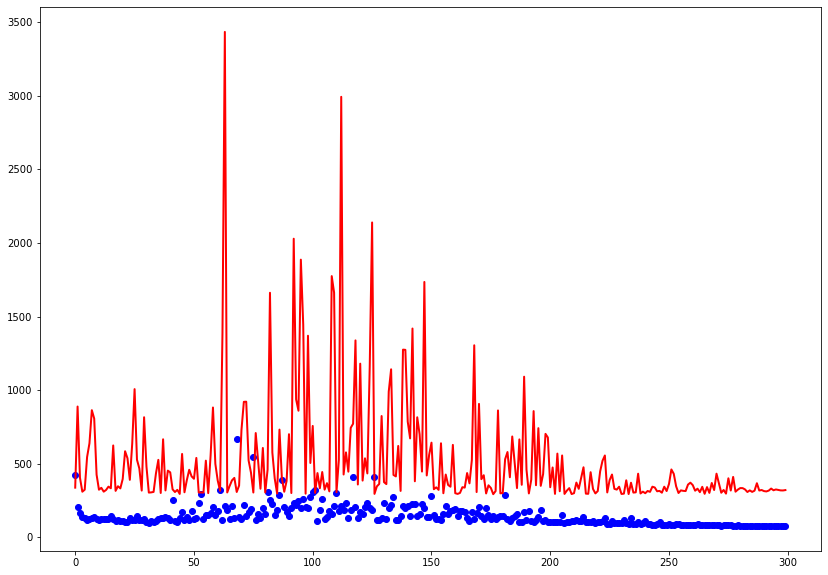

In [19]:
fig, ax = plot.subplots(figsize=(14, 10))
ax.plot(metrics["MAE"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["MAE_val"], '-r', linewidth=2, label="Validation Loss")

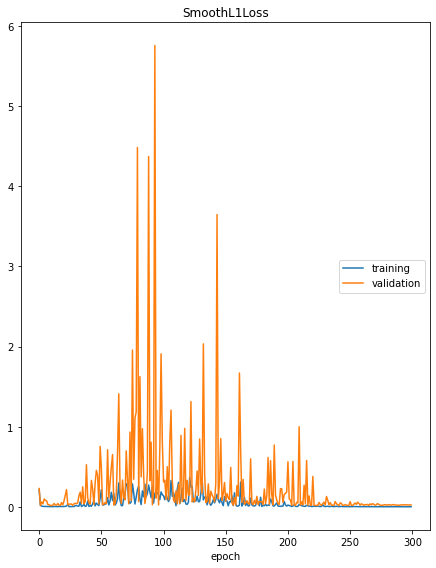

Epoch[300/300]: 100%|█| 300/300 [01:36<00:00,  3.11it/s, SmoothL1Loss=0.0016, M


In [20]:
model = NeuralProphet(n_changepoints=100,
                      trend_reg=0.5,
                      yearly_seasonality=True,
                      weekly_seasonality=False,
                      daily_seasonality=False)
metrics = model.fit(prcp_data, validate_each_epoch=True, 
                    valid_p=0.2, freq='D', 
                    plot_live_loss=True, 
                    epochs=300)

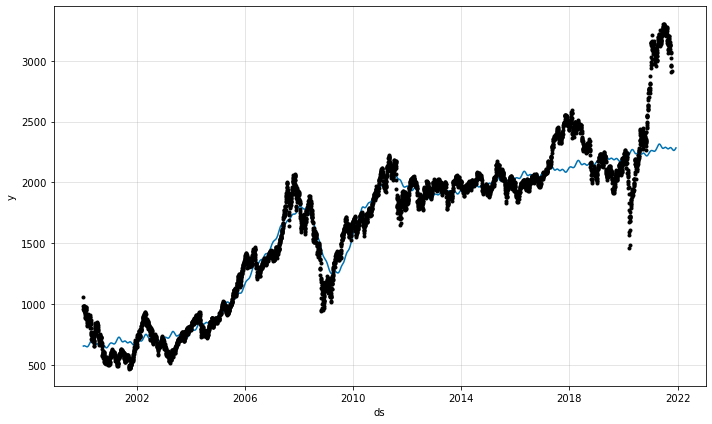

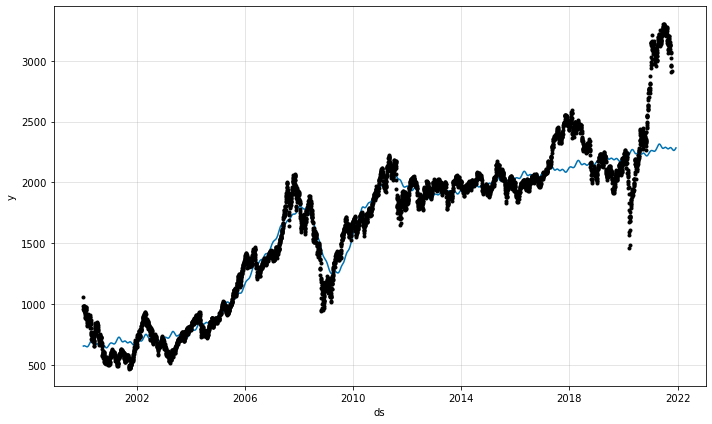

In [21]:
future = model.make_future_dataframe(prcp_data, periods=60, n_historic_predictions=True)
forecast = model.predict(future)
model.plot(forecast)

In [22]:
model = NeuralProphet(
    n_forecasts=60,
    n_lags=60,
    n_changepoints=100,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    batch_size=64,
    epochs=100,
    learning_rate=1.0,
)
model.fit(prcp_data, 
          freq='D',
          valid_p=0.2,
          epochs=300)

INFO: nprophet - _handle_missing_data: 2577 missing dates were added.
INFO: nprophet - _handle_missing_data: 2577 NaN values in column y were auto-imputed.
Epoch[300/300]: 100%|█| 300/300 [06:31<00:00,  1.30s/it, SmoothL1Loss=0.000671,


,SmoothL1Loss,MAE,RegLoss
0,0.061088,501.256369,0.0
1,0.001373,89.231984,0.0
2,0.001101,79.819429,0.0
3,0.001188,83.516024,0.0
4,0.001232,85.453928,0.0
...,...,...,...
295,0.000698,61.146954,0.0
296,0.000684,60.240372,0.0
297,0.000675,59.852054,0.0
298,0.000673,59.660027,0.0


INFO: nprophet - _handle_missing_data: 2577 missing dates were added.
INFO: nprophet - _handle_missing_data: 2577 NaN values in column y were auto-imputed.


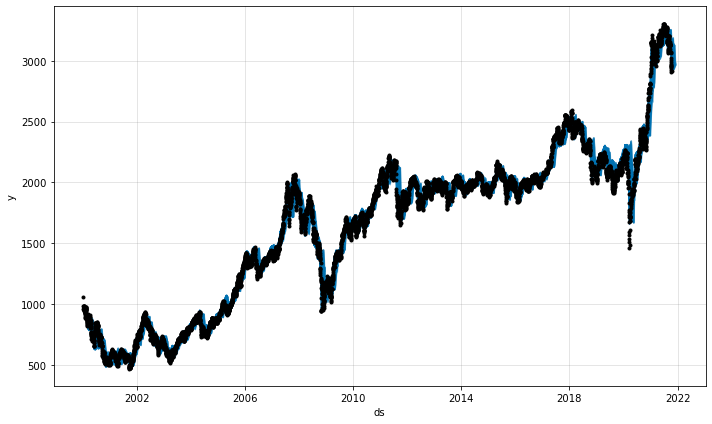

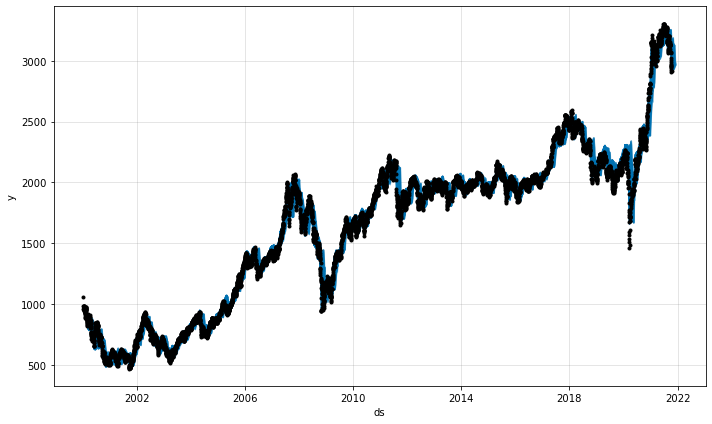

In [23]:
future = model.make_future_dataframe(prcp_data, periods=60, n_historic_predictions=True)
forecast = model.predict(future)
model.plot(forecast)